In [4]:
import tensorflow as tf
from tensorflow.keras import Model
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import random as rd
import sys
import os

sys.path.append("..")

from AllMethods import PerturbedPendulum_Methods as pp

In [5]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.2)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [6]:
x, y = pp.read_dataset('x_train.txt', 'y_train.txt')
train_dataset, val_dataset = pp.train_dataset(x, y, 20, 180, 20) #val_len, train_batch, val_batch

In [7]:
#MLPs #####################

class MLP1(tf.keras.layers.Layer):
    
    def __init__(self):
        super(MLP1, self).__init__()

    def build(self, input_shape):
        
        self.L1 = tf.keras.layers.Dense(3, activation='tanh')
        self.L2 = tf.keras.layers.Dense(3, activation='tanh')
        self.L3 = tf.keras.layers.Dense(2, activation='tanh')


    def call(self, inputs, training=False):
        
        h = self.L1(inputs)
        h = self.L2(h)
        h = self.L3(h)
        
        return h



class MLP2(tf.keras.layers.Layer):
    
    def __init__(self):
        super(MLP2, self).__init__()

    def build(self, input_shape):
        
        self.L1 = tf.keras.layers.Dense(6, activation='tanh')
        self.L2 = tf.keras.layers.Dense(6, activation='tanh')
        self.L3 = tf.keras.layers.Dense(6, activation='tanh')
        self.L4 = tf.keras.layers.Dense(2, activation='tanh')


    def call(self, inputs, training=False):
        
        h = self.L1(inputs)
        h = self.L2(h)
        h = self.L3(h)
        h = self.L4(h)
        
        return h



class MLP3(tf.keras.layers.Layer):
    
    def __init__(self):
        super(MLP3, self).__init__()

    def build(self, input_shape):
        
        self.L1 = tf.keras.layers.Dense(12, activation='tanh')
        self.L2 = tf.keras.layers.Dense(12, activation='tanh')
        self.L3 = tf.keras.layers.Dense(12, activation='tanh')
        self.L4 = tf.keras.layers.Dense(12, activation='tanh')
        self.L5 = tf.keras.layers.Dense(2, activation='tanh')


    def call(self, inputs, training=False):
        
        h = self.L1(inputs)
        h = self.L2(h)
        h = self.L3(h)
        h = self.L4(h)
        h = self.L5(h)

        return h


####################################################################
####################################################################
####################################################################

def get_shift_and_log_scale_resnet(input_shape, blocks, shift):
    
    inputs = tf.keras.Input(shape=input_shape)
    h = inputs

    for block in blocks:
        h = block(h)

    shift, log_scale = shift(inputs), h
    log_scale = tf.math.tanh(log_scale)
    return Model(inputs=inputs, outputs=[shift, log_scale], name='name')
    
    
    
class AffineCouplingLayer(layers.Layer):

    def __init__(self, shift_and_log_scale_fn, mask):
        
        super(AffineCouplingLayer, self).__init__()
        self.shift_and_log_scale_fn = shift_and_log_scale_fn
        self.b = tf.cast(mask, tf.float32)

    def call(self, x, inverse):
        
        if inverse == 1:
            t, log_s = self.shift_and_log_scale_fn(x * self.b)
            y = self.b * x + (1 - self.b) * (x * tf.exp(log_s) + t)
            return y
        
        if inverse == 0:
            t, log_s = self.shift_and_log_scale_fn(x * self.b)
            y = self.b * x + (1 - self.b) * ((x - t) * tf.exp(-log_s))
            return y


class R(tf.keras.layers.Layer):

    def __init__(self):
        super(R, self).__init__()
        
    def call(self, inputs):
        return inputs*tf.constant([[1., -1.]])
    

class RealNVPModel(tf.keras.Model):
    
    def __init__(self, shift_and_log_scale, **kwargs):
        
        super(RealNVPModel, self).__init__()
        self.R = R()
        masks = []
        self.l = []
        
        for j in range(len(shift_and_log_scale)):
            
            if j%2==0:
                masks.append(tf.constant([[0., 1.]]))
            else:
                masks.append(tf.constant([[1., 0.]]))

        
        for i,j in zip(shift_and_log_scale, masks):
            self.l.append(AffineCouplingLayer(i, j))
        

    def call(self, input_tensor):
        
        a = self.R(input_tensor)
        
        for layer in self.l:
            a = layer(a, 1)

        a = self.R(a)

        for layer in self.l[::-1]:
            a = layer(a, 0)
        
        return a
    
###############################################################################
    
    
num_blocks = 6

blocks1 = [MLP1() for i in range(num_blocks)]
shifts1 = [MLP1() for i in  range(num_blocks)]
shift_and_log_scale1 = [get_shift_and_log_scale_resnet((2), [i], j) for i,j in zip(blocks1, shifts1)]
model1 = RealNVPModel(shift_and_log_scale1)


blocks2 = [MLP2() for i in range(num_blocks)]
shifts2 = [MLP2() for i in  range(num_blocks)]
shift_and_log_scale2 = [get_shift_and_log_scale_resnet((2), [i], j) for i,j in zip(blocks2, shifts2)]
model2 = RealNVPModel(shift_and_log_scale2)

num_blocks = 6

blocks3 = [MLP3() for i in range(num_blocks)]
shifts3 = [MLP3() for i in  range(num_blocks)]
shift_and_log_scale3 = [get_shift_and_log_scale_resnet((2), [i], j) for i,j in zip(blocks3, shifts3)]
model3 = RealNVPModel(shift_and_log_scale3)


###############################################################################

In [8]:
# DECAYING LEARNING RATE
def scheduler(epoch, lr):
    if epoch%100==0:
        print("epoch: ", epoch)
    if epoch < 5:
        return lr
    else:
        return lr*tf.math.exp(-0.0002)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [9]:
checkpoint_path_2 = "checkpoints_RNN_HH_2/cp.ckpt"
checkpoint_dir_2 = os.path.dirname(checkpoint_path_2)

In [10]:
cp_callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_2,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=0)

In [11]:
model2.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=["accuracy"],
)

In [12]:
Epochs = 3000

history2 = model2.fit(train_dataset, epochs = Epochs, validation_data=val_dataset, callbacks=[callback, cp_callback_2], verbose=0)

epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900


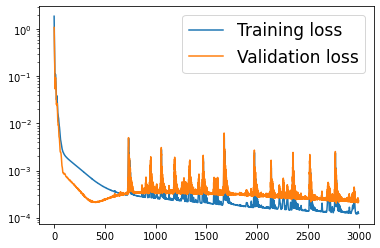

In [13]:
plt.plot(history2.history["loss"], label="Training loss")
plt.plot(history2.history["val_loss"], label="Validation loss")
plt.yscale("log")
plt.legend(fontsize=17)
plt.show()

In [ ]:
f = open("HM_RNN_Loss.txt", "a")
for i in history2.history["loss"]:
        f.write(str(i))
        f.write("\n")
f.close()

f = open("HM_RNN_Val.txt", "a")
for i in history2.history["val_loss"]:
        f.write(str(i))
        f.write("\n")
f.close()

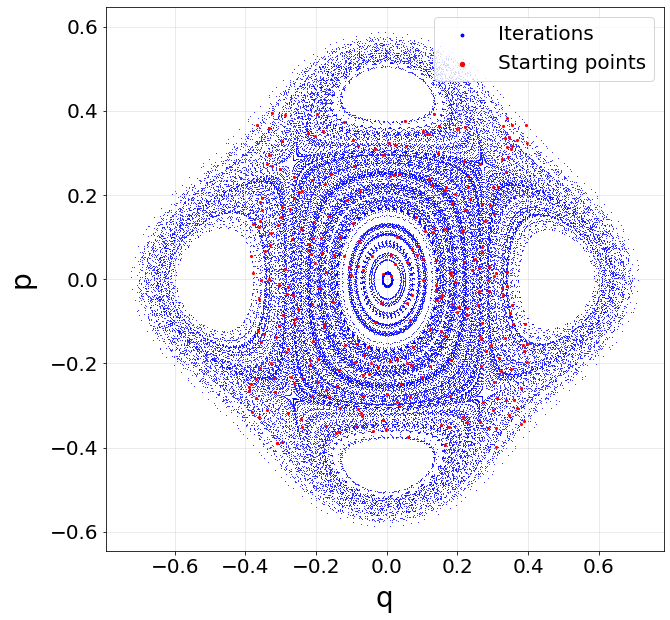

In [14]:
N = 300
x0 = np.array([[rd.randrange(-400, 400, 1)*0.001, rd.randrange(-400, 400, 1)*0.001] for _ in range(N)])
iterations = [model2(x0)]
for _ in range(200):
    iterations.append(model2(iterations[-1]))
    
plt.figure(figsize=(10,10))
colors = []
sizes = []
for i in range(N):
    if i==18:
        colors.append("r")
        sizes.append(10)
    else:
        colors.append("b")
        sizes.append(1)

plt.scatter(*zip(*iterations[0].numpy()), s=1, linewidth=0, color="b", label = "Iterations")

for i in iterations:
    plt.scatter(*zip(*i.numpy()), s=1, linewidth=0, color="b")
    
plt.scatter(*zip(*x0), s=10, linewidth=0, color="r", label = "Starting points")


plt.xlabel("q", fontsize=28, labelpad=8)
plt.ylabel("p", fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
lgnd = plt.legend(loc="upper right", numpoints=1, fontsize=20)
lgnd.legendHandles[0]._sizes = [15]
lgnd.legendHandles[1]._sizes = [30]
plt.show()